#### S2S centroids plot overplot the shapefile of each watershed
Ming Ge Oct 2023

 Water vapor mixing ratio at 850 hPa (Q850) anomaly normalized anomaly
 Re-label the WTs so that: 0=Monsoon, 1=Normal, 2=Dry

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [16]:
dir_shp = '/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/'
dir_data = '/glade/campaign/mmm/c3we/mingge/COEXIST/AZ_S2S_DATA/'

RegName_1d = ['Arizona West','Arizona East', 'NM North',  'NM South']
n_region = len(RegName_1d)
sWTdata_1d = [None] * n_region
flnm_shp_1d = [None] * n_region

relabel_wt = ['Monsoon', 'Normal', 'Dry']

for nr in range(n_region):
    if RegName_1d[nr] == 'Arizona West':
        sWTdata_1d[nr] = dir_data + 'Clusters13514_1501_1982-2018_Q850_JJASO'
        flnm_shp_1d[nr] = dir_shp + 'AZ_West.shp'
    if RegName_1d[nr] == 'Arizona East':
        sWTdata_1d[nr] = dir_data + 'Clusters13514_1502_1982-2018_Q850_JJASO'
        flnm_shp_1d[nr] = dir_shp + 'AZ_East.shp'
    if RegName_1d[nr] == 'NM North':
        sWTdata_1d[nr] = dir_data + 'Clusters13514_HUC6-00_1982-2018_Q850_JJASO'
        flnm_shp_1d[nr] = dir_shp + 'NM_North.shp'
    if RegName_1d[nr] == 'NM South':
        sWTdata_1d[nr] = dir_data + 'Clusters13514_HUC6-03_1982-2018_Q850_JJASO'
        flnm_shp_1d[nr] = dir_shp + 'NM_South.shp'
        

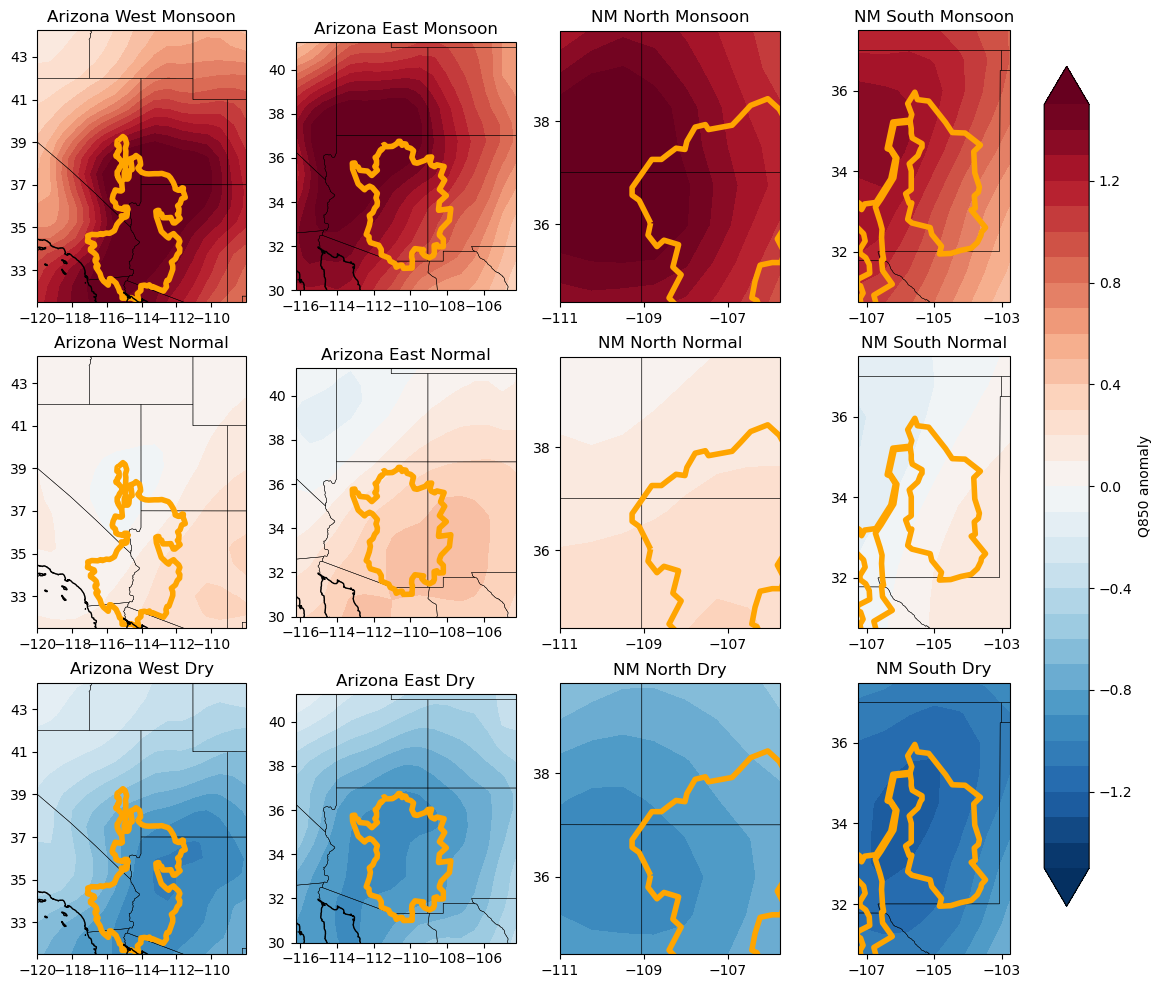

In [17]:
proj = ccrs.PlateCarree()
n_wt = 3
# Set up a standard map for latlon data for multiple subplots
fig, ax = plt.subplots(n_wt, n_region,figsize=(15, 12), subplot_kw={'projection': proj})

levels = np.linspace(-1.5, 1.5, 31) 

for nr in range(n_region):
    # load shapefile
    shp_gpd = gpd.read_file(flnm_shp_1d[nr])
    if RegName_1d[nr] == 'Arizona West':
        WTsort = [0,2,1]
    elif RegName_1d[nr] == 'Arizona East' or RegName_1d[nr] == 'NM North':
        WTsort = [1,2,0]
    else:
        WTsort = [0,1,2]
    
    # Load the Centroids
    with open(sWTdata_1d[nr], 'rb') as handle:
        npzfile = pickle.load(handle)
    
        WTclusters=npzfile['grClustersFin']['Full']
        WTlat=npzfile['LatWT']     
        WTlon=npzfile['LonWT'] 

        # WTlon[WTlon<0] = WTlon[WTlon<0]+360
        lon_1d = WTlon[0, :]
        lat_1d = WTlat[:, 0]

        centroid_3d = np.reshape(WTclusters[0], (WTclusters[0].shape[0],WTlat.shape[0], WTlat.shape[1]))
 
        n_wt = centroid_3d.shape[0]
   
    # Re-label the WTs so that: 0=Monsoon, 1=Normal, 2=Dry
    centroid_3d_new = np.copy(centroid_3d)
    for nw in range(n_wt):
        centroid_3d_new[nw] = centroid_3d[WTsort[nw]]

    for nw in range(n_wt):
         # Make a filled contour plot
        filled_c = ax[nw, nr].contourf(lon_1d, lat_1d, centroid_3d_new[nw], extend='both',
                                       levels = levels, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        
        # Add coastlines
        ax[nw, nr].coastlines()
        ax[nw, nr].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
        ax[nw, nr].set_title(RegName_1d[nr] + ' ' + relabel_wt[nw])

        # plot the lat lon labels
        #xticks = np.arange(lon_1d.min(), lon_1d.max(), 2) 
        #yticks = np.arange(lat_1d.min(), lat_1d.max(), 2)  
        xticks = np.arange(int(lon_1d.min()), int(lon_1d.max()), 2) 
        yticks = np.arange(int(lat_1d.min()), int(lat_1d.max()), 2)  
        ax[nw, nr].set_xticks(xticks, crs=cartopy.crs.PlateCarree())
        ax[nw, nr].set_yticks(yticks, crs=cartopy.crs.PlateCarree())
        
        # add shapefile outline
        shp_gpd.plot(ax = ax[nw,nr], edgecolor='orange', color='none', linewidth=4)
        ax[nw, nr].set_xlim(lon_1d.min(), lon_1d.max())
        ax[nw, nr].set_ylim(lat_1d.min(), lat_1d.max())

        # Add a colorbar for the filled contour.
        # and pad argument to set colorbar away from x-axis
        #fig.colorbar(filled_c , orientation="horizontal", pad = 0.1);
           
fig.subplots_adjust(right=0.8)
# rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
cbar_ax.set_label('anomaly') #rotation=270)
 
clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both')
clb.set_label('Q850 anomaly');

#### CONUS 12 Weather type

In [21]:
sCentroids = '/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA = np.load(sCentroids)
rgrCentroids = DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs = range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 
n_wt  = rgrCentroids.shape[0]
n_var = rgrCentroids.shape[1]
n_lat = rgrCentroids.shape[2]
n_lon = rgrCentroids.shape[3]

rgrLatWT=DATA['rgrLatWT']  
rgrLonWT=DATA['rgrLonWT'] 

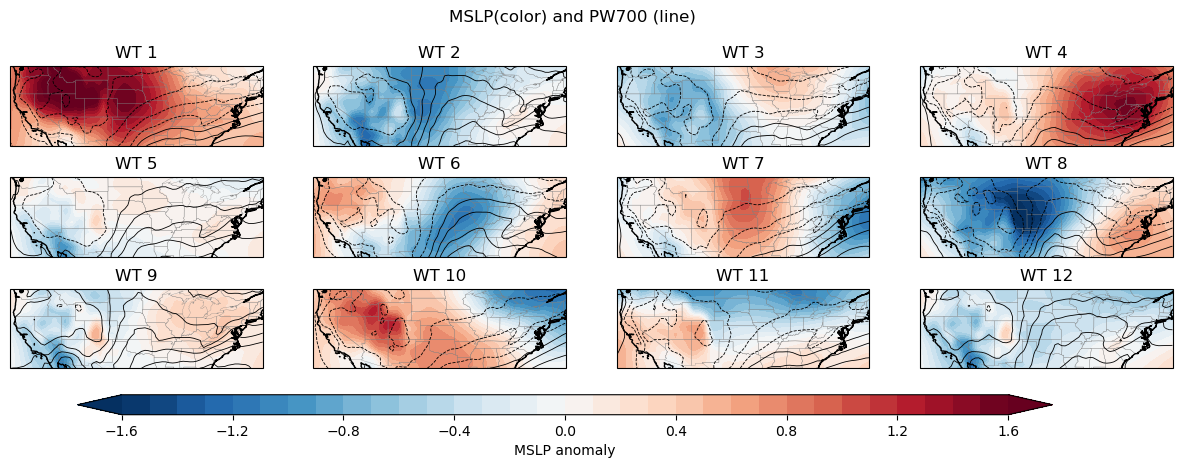

In [24]:
 
# Set up a standard map for latlon data for multiple subplots
fig, axs = plt.subplots(3, 4, figsize=(15, 5), subplot_kw={'projection': proj})
 
ct = 0
levels = np.linspace(-1.6, 1.6, 33)

for nr in range(0,3):
    for nc in range(0,4):
        msl=axs[nr,nc].contourf(rgrLonWT, rgrLatWT, rgrCentroids[ct,0], levels=levels, cmap='RdBu_r', extend='both')
        # pw =axs[nr,nc].contour(rgrLonWT, rgrLatWT, rgrCentroids[ct,2],colors='k')
        axs[nr,nc].contour(rgrLonWT, rgrLatWT, rgrCentroids[ct,2], colors='k', linewidths=.6)
        # Add coastlines
        axs[nr, nc].coastlines()
        axs[nr, nc].add_feature(cfeature.STATES, zorder=1, linewidth=.2, edgecolor='grey')
         
        ct +=1
        axs[nr,nc].title.set_text("WT " + str(ct))

# Set a Single Main Title for All the Subplots
fig.suptitle('MSLP(color) and PW700 (line)', fontsize=12)

# rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
 
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.04])
clb = fig.colorbar(msl, cax=cbar_ax, orientation="horizontal", extend='both');
clb.set_label('MSLP anomaly')